# Imports


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.naive_bayes import GaussianNB
import csv
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing as pre
from sklearn import impute
from sklearn.pipeline import Pipeline 

import pandas as pd
import scipy.sparse as sp
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import time


# Feature Reduced Data, Downsampled Set

In [20]:
knnData = pd.read_csv('./data/train_data_clean_reduced_encoded.csv')
knnDf = pd.DataFrame(knnData)
X = knnDf
#print(knnDf.columns)
ynn = list(knnDf.iloc[:,0])
#print(ynn)
knn = knnDf.drop(columns=["0"])
xnn_train, xnn_test, ynn_train, y_test = train_test_split(knn, ynn, test_size=0.2, random_state=0)
print(knn.shape)


(34474, 533)


In [24]:
data =  pd.read_csv('./data/train_data_clean_reduced_encoded.csv')
df = pd.DataFrame(data)


X = df

#Downsampling

#mult is ratio of legitimate data to fraudulent data
mult = 1

fClass = X[X['0'] == 1]
lClass = X[X['0'] == 0]

fCount = int(len(fClass) * mult)

#downsample
lClass = lClass.sample(fCount, axis=0)

X = pd.concat([fClass.reset_index(drop=True), lClass.reset_index(drop=True)],axis=0)

#shuffle data
X.sample(frac = 1)
y =np.array(X['0'])
X = X.drop(columns=['0'])

#End downsampling


xnn_train, xnn_test, ynn_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [26]:
print(xnn_train.shape)

(27532, 159)


# Testing new data

### Helper Functions

In [25]:
def pw4(y_pred):
    isC0 = np.equal(y_pred,0) * 1
    isC1 = np.equal(y_pred,1) * 1
    isC2 = np.equal(y_pred,2) * 1
    isC3 = np.equal(y_pred,3) * 1
    #count of isFraud found in each cluster
    count0 = np.sum(np.logical_and(y_test,isC0)) 
    count1 = np.sum(np.logical_and(y_test,isC1))
    count2 = np.sum(np.logical_and(y_test,isC2))
    count3 = np.sum(np.logical_and(y_test,isC3))
    countArray = np.array([count0, count1, count2, count3])

    #size of each cluster
    size0 = np.sum(isC0)
    size1 = np.sum(isC1)
    size2 = np.sum(isC2)
    size3 = np.sum(isC3)
    sizeArray = np.array([size0, size1, size2, size3])

    #fraction of fraud in each cluster
    f0 = count0 / size0
    f1 = count1 / size1
    f2 = count2/ size2
    f3 = count3 / size3
    fractionArray = np.array([f0,f1,f2,f3])

    fraudIndex = np.argmax(fractionArray[np.logical_not(np.isnan(fractionArray))])
    #For every array, swap fraud to index 0
    temp = countArray[0]
    countArray[0] = countArray[fraudIndex]
    countArray[fraudIndex] = temp

    temp = sizeArray[0]
    sizeArray[0] = sizeArray[fraudIndex]
    sizeArray[fraudIndex] = temp

    temp = fractionArray[0]
    fractionArray[0] = fractionArray[fraudIndex]
    fractionArray[fraudIndex] = temp

    TP = countArray[0]
    TN = sizeArray[1] + sizeArray[2] + sizeArray[3] - countArray[1] - countArray[2] - countArray[3]
    FP = sizeArray[0] - countArray[0]
    FN = countArray[1] + countArray[2] + countArray[3]
    N = TP+TN+FP+FN
    return TP,TN,FP,FN,N

def pw2(y_pred):
    isC0 = np.equal(y_pred,0) * 1
    isC1 = np.equal(y_pred,1) * 1
    #count of isFraud found in each cluster
    count0 = np.sum(np.logical_and(y_test,isC0)) 
    count1 = np.sum(np.logical_and(y_test,isC1))
    countArray = np.array([count0, count1])
    #size of each cluster
    size0 = np.sum(isC0)
    size1 = np.sum(isC1)
    
    sizeArray = np.array([size0, size1])
    #fraction of fraud in each cluster
    f0 = count0 / size0
    f1 = count1 / size1
    fractionArray = np.array([f0,f1])
    fraudIndex = np.argmax(fractionArray)
    #For every array, swap fraud to index 0
    temp = countArray[0]
    countArray[0] = countArray[fraudIndex]
    countArray[fraudIndex] = temp

    temp = sizeArray[0]
    sizeArray[0] = sizeArray[fraudIndex]
    sizeArray[fraudIndex] = temp

    temp = fractionArray[0]
    fractionArray[0] = fractionArray[fraudIndex]
    fractionArray[fraudIndex] = temp

    TP = countArray[0]
    TN = sizeArray[1] - countArray[1]
    FP = sizeArray[0] - countArray[0]
    FN = countArray[1]
    N = TP+TN+FP+FN
    return TP,TN,FP,FN,N
    
def getMaxCluster(y_pred):
    isC0 = np.equal(y_pred,0) * 1
    isC1 = np.equal(y_pred,1) * 1
    isC2 = np.equal(y_pred,2) * 1
    isC3 = np.equal(y_pred,3) * 1
    #count of isFraud found in each cluster
    count0 = np.sum(np.logical_and(y_test,isC0)) 
    count1 = np.sum(np.logical_and(y_test,isC1))
    count2 = np.sum(np.logical_and(y_test,isC2))
    count3 = np.sum(np.logical_and(y_test,isC3))
    countArray = np.array([count0, count1, count2, count3])

    #size of each cluster
    size0 = np.sum(isC0)
    size1 = np.sum(isC1)
    size2 = np.sum(isC2)
    size3 = np.sum(isC3)
    sizeArray = np.array([size0, size1, size2, size3])

    #fraction of fraud in each cluster
    f0 = count0 / size0
    f1 = count1 / size1
    f2 = count2/ size2
    f3 = count3 / size3
    fractionArray = np.array([f0,f1,f2,f3])

    return np.argmax(fractionArray[np.logical_not(np.isnan(fractionArray))])



In [34]:
#Loop through number of features, test kmeans, gmm once at every level of feature
scaler = StandardScaler()
scaler.fit(xnn_test)
scaled_data = scaler.transform(xnn_test)
length = 15

kPrecision = np.zeros(length)
kRecall = np.zeros(length)
kF = np.zeros(length)
kBalanced = np.zeros(length)
kRS = np.zeros(length)
kJC = np.zeros(length)

gmm2Precision = np.zeros(length)
gmm2Recall = np.zeros(length)
gmm2F = np.zeros(length)
gmm2Balanced = np.zeros(length)
gmm2RS = np.zeros(length)
gmm2JC = np.zeros(length)


gmm4Precision = np.zeros(length)
gmm4Recall = np.zeros(length)
gmm4F = np.zeros(length)
gmm4Balanced = np.zeros(length)
gmm4RS = np.zeros(length)
gmm4JC = np.zeros(length)

numIters = 10
index = 0
for numFeatures in range(0, 159, 11):
    print(numFeatures)
    done = False
    if numFeatures > 158:
        numFeatures = 158
        done=True
    for numTimes in range(numIters):
        x_pca = scaled_data
        #fit, predict each model
        kmeans = KMeans(n_clusters=2, init='k-means++', n_init='auto').fit(x_pca)
        kmeansY = kmeans.predict(x_pca)
        gmm2 = GaussianMixture(n_components=2, init_params='k-means++').fit(x_pca)
        gmm2Y = gmm2.predict(x_pca)
        gmm4 = GaussianMixture(n_components=4, init_params='k-means++').fit(x_pca)
        gmm4Y = gmm4.predict(x_pca)
        #PW Each Model
        gmm4TP, gmm4TN, gmm4FP, gmm4FN, gmm4N = pw4(gmm4Y)
        gmm2TP, gmm2TN, gmm2FP, gmm2FN, gmm2N = pw2(gmm2Y)
        kTP, kTN, kFP, kFN, kN = pw2(kmeansY)

        kPrecision[index] += kTP/(kTP+kFP)
        kRecall[index] += kTP / (kTP+kFN)
        kF[index] += kPrecision[index] * kRecall[index] / (kPrecision[index] + kRecall[index])
        kBalanced[index] += 0.5 * (kTP/(kTP + kFN) + kTN/(kTN + kFP))
        kRS[index] += (kTP + kTN)/kN
        kJC[index] += kTP/(kTP+kFN+kFP)


        gmm2Precision[index] += gmm2TP/(gmm2TP+gmm2FP)
        gmm2Recall[index] += gmm2TP / (gmm2TP+gmm2FN)
        gmm2F[index] += gmm2Precision[index] * gmm2Recall[index] / (gmm2Precision[index] + gmm2Recall[index])
        gmm2Balanced[index] += 0.5 * (gmm2TP/(gmm2TP + gmm2FN) + gmm2TN/(gmm2TN + gmm2FP))
        gmm2RS[index] += (gmm2TP + gmm2TN)/gmm2N
        gmm2JC[index] += gmm2TP/(gmm2TP+gmm2FN+gmm2FP)


        gmm4Precision[index] += gmm4TP/(gmm4TP+gmm4FP)
        gmm4Recall[index] += gmm4TP / (gmm4TP+gmm4FN)
        gmm4F[index] += gmm4Precision[index] * gmm4Recall[index] / (gmm4Precision[index] + gmm4Recall[index])
        gmm4Balanced[index] += 0.5 * (gmm4TP/(gmm4TP + gmm4FN) + gmm4TN/(gmm4TN + gmm4FP))
        gmm4RS[index] += (gmm4TP + gmm4TN)/gmm4N
        gmm4JC[index] += gmm4TP/(gmm4TP+gmm4FN+gmm4FP)
    index += 1
    if done:
        break

kPrecision /= numIters
kRecall /= numIters
kF /= numIters
kBalanced /= numIters
kRS /= numIters
kJC /= numIters


gmm2Precision /= numIters
gmm2Recall /= numIters
gmm2F /= numIters
gmm2Balanced /= numIters
gmm2RS /= numIters
gmm2JC /= numIters


gmm4Precision /= numIters
gmm4Recall /= numIters
gmm4F /= numIters
gmm4Balanced /= numIters
gmm4RS /= numIters
gmm4JC /= numIters

0
11
22
33
44
55
66
77
88
99
110


c:\Users\Keyes Eames\anaconda3\lib\site-packages\sklearn\mixture\_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


121
132
143
154


In [35]:
kF2 = 2 * kPrecision * kRecall / (kPrecision + kRecall)
gmm2F2 = 2 * gmm2Precision * gmm2Recall / (gmm2Precision + gmm2Recall)
gmm4F2 = 2 * gmm4Precision * gmm4Recall / (gmm4Precision + gmm4Recall)

In [36]:
hoAxis = np.arange(length)

# Evaluation of K Means

(0.0, 1.0)

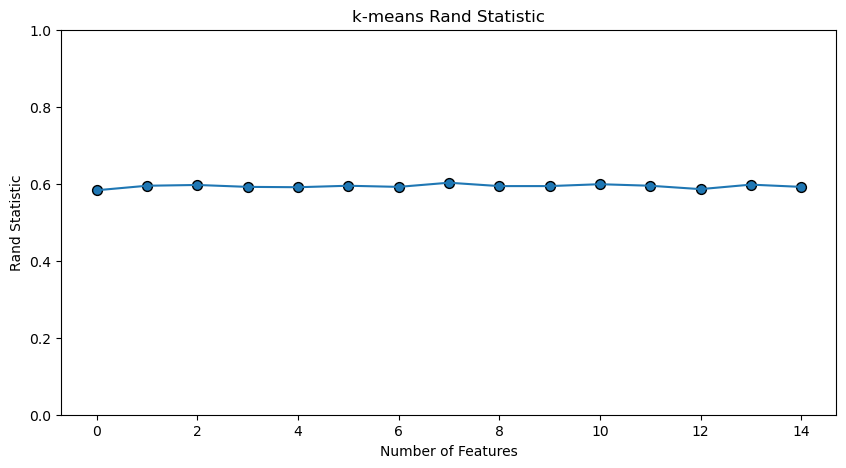

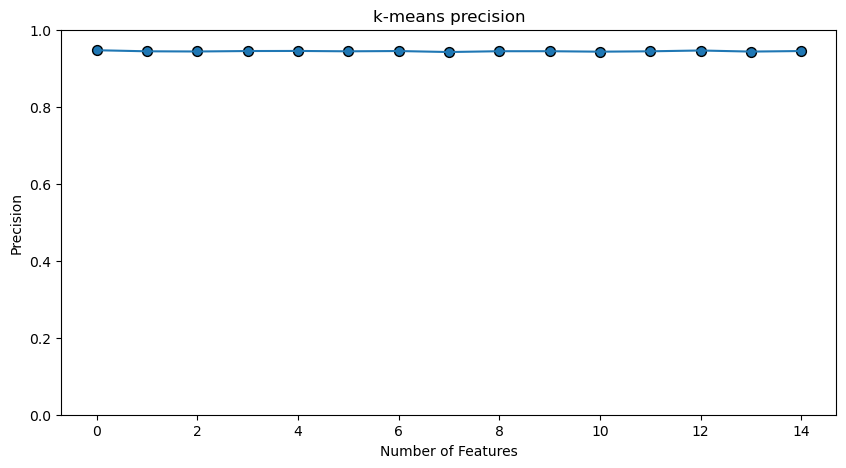

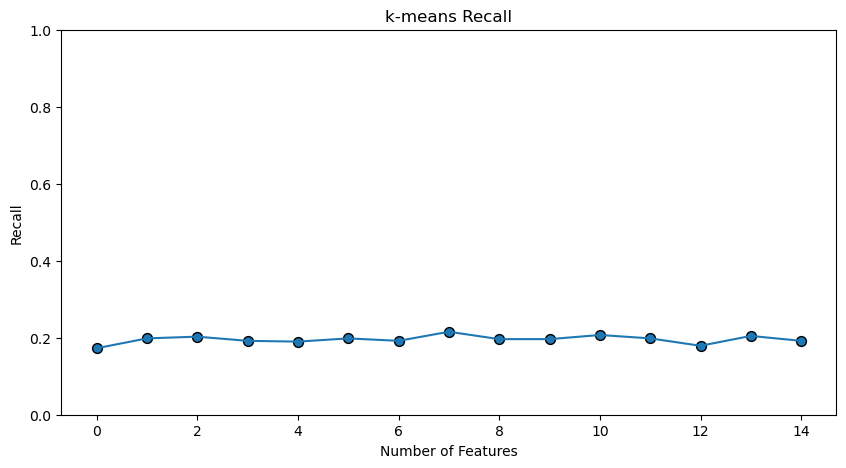

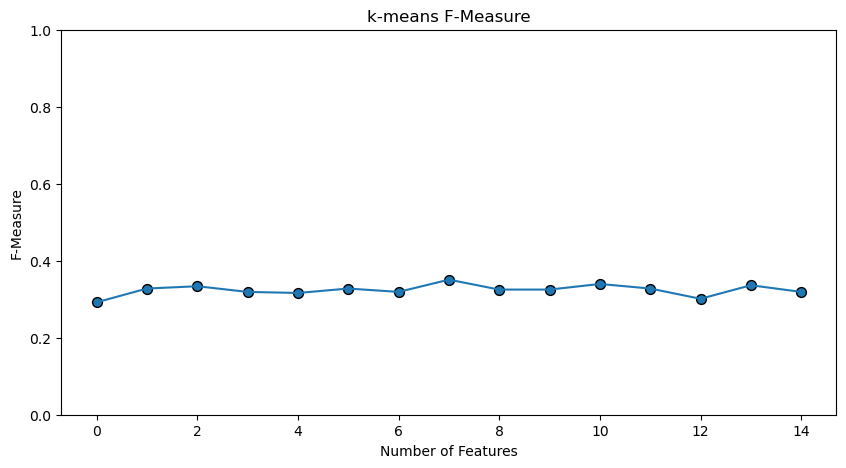

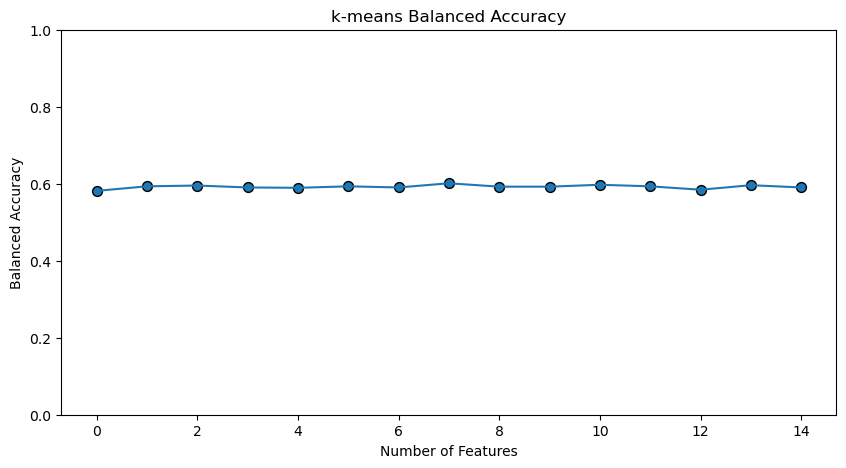

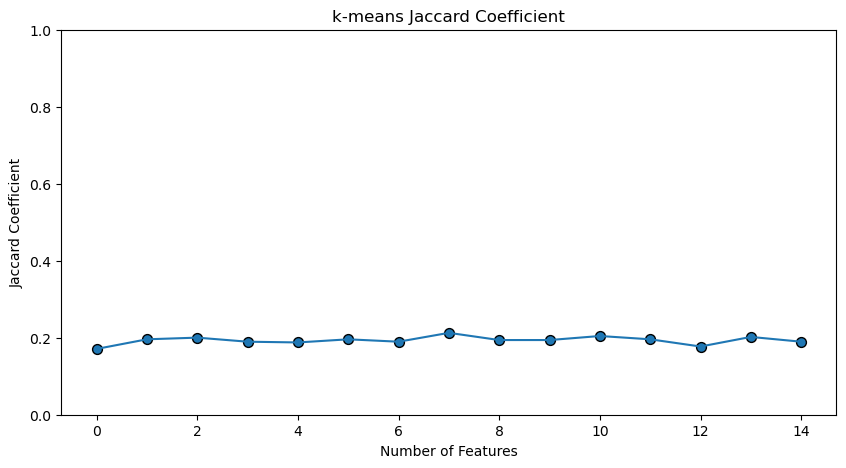

In [37]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, kRS, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, kRS)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Rand Statistic")
ax.set_title("k-means Rand Statistic")
ax.set_ylim([0,1])


fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, kPrecision, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, kPrecision)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Precision")
ax.set_title("k-means precision")
ax.set_ylim([0,1])


fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, kRecall, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, kRecall)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Recall")
ax.set_title("k-means Recall")
ax.set_ylim([0,1])



fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, kF2, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, kF2)
ax.set_xlabel("Number of Features")
ax.set_ylabel("F-Measure")
ax.set_title("k-means F-Measure")
ax.set_ylim([0,1])




fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, kBalanced, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, kBalanced)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Balanced Accuracy")
ax.set_title("k-means Balanced Accuracy")
ax.set_ylim([0,1])


fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, kJC, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, kJC)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Jaccard Coefficient")
ax.set_title("k-means Jaccard Coefficient")
ax.set_ylim([0,1])




In [38]:
temp = np.max(kPrecision)
print("The maximum precision was", temp)
temp = np.max(kRecall[1:])
print("The maximum nontrivial recall was", temp)
temp = np.max(kF2)
print("The maximum F-measure was", temp)
temp = np.max(kBalanced)
print("The maximum balanced accuracy was", temp)
temp = np.max(kRS)
print("The maximum Rand Statistic was", temp)
temp = np.max(kJC)
print("The maximum Jaccard Coefficient was", temp)

The maximum precision was 0.946712802768166
The maximum nontrivial recall was 0.21551472732575094
The maximum F-measure was 0.35078244766958905
The maximum balanced accuracy was 0.6011582319696771
The maximum Rand Statistic was 0.6026147588611274
The maximum Jaccard Coefficient was 0.21265636229995316


In [39]:
temp = np.average(kPrecision)
print("The average precision was", temp)
temp = np.average(kRecall)
print("The average nontrivial recall was", temp)
temp = np.average(kF2)
print("The average F-measure was", temp)
temp = np.average(kBalanced)
print("The average balanced accuracy was", temp)
temp = np.average(kRS)
print("The average Rand Statistic was", temp)
temp = np.average(kJC)
print("The average Jaccard Coefficient was", temp)

The average precision was 0.9442284391228694
The average nontrivial recall was 0.19565470982793814
The average F-measure was 0.32401209631284905
The average balanced accuracy was 0.5920328541903801
The average Rand Statistic was 0.5935299244625216
The average Jaccard Coefficient was 0.19331987042638182


In [33]:
temp = np.var(kPrecision)
print("The variance of precision was", temp)
temp = np.var(kRecall[1:])
print("The variance of recall was", temp)
temp = np.var(kF2)
print("The variance of F-measure was", temp)
temp = np.var(kBalanced)
print("The variance of balanced accuracy was", temp)
temp = np.var(kRS)
print("The variance of Rand Statistic was", temp)
temp = np.var(kJC)
print("The variance of Jaccard Coefficient was", temp)

The variance of precision was 1.0642699307825427e-05
The variance of recall was 0.0008400677477147904
The variance of F-measure was 0.0017332748286323645
The variance of balanced accuracy was 0.00019305342954552046
The variance of Rand Statistic was 0.00019134120373856132
The variance of Jaccard Coefficient was 0.0008667443261064609


# Evaluation of GMM With 2 Clusters

(0.0, 1.0)

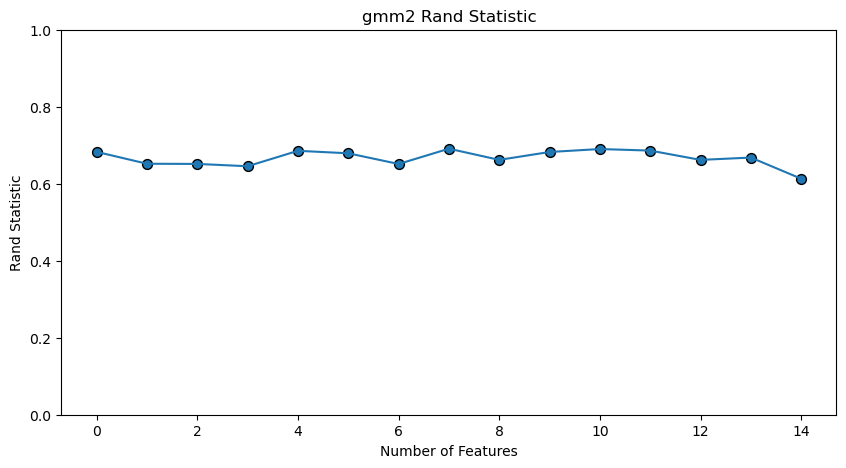

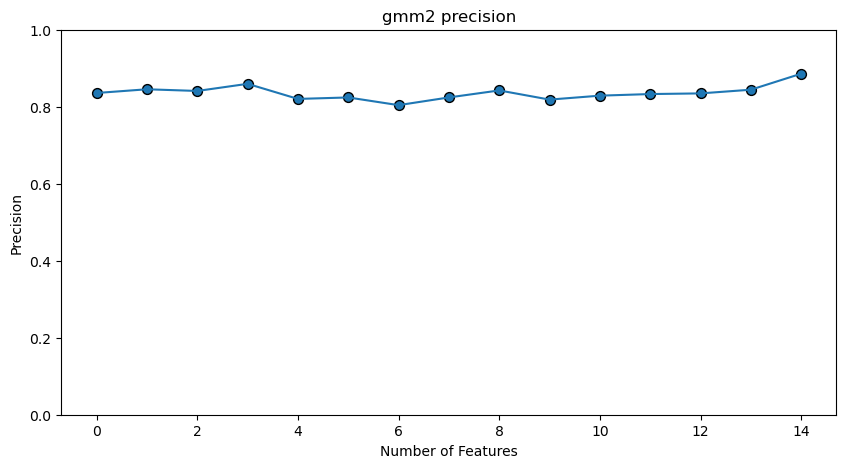

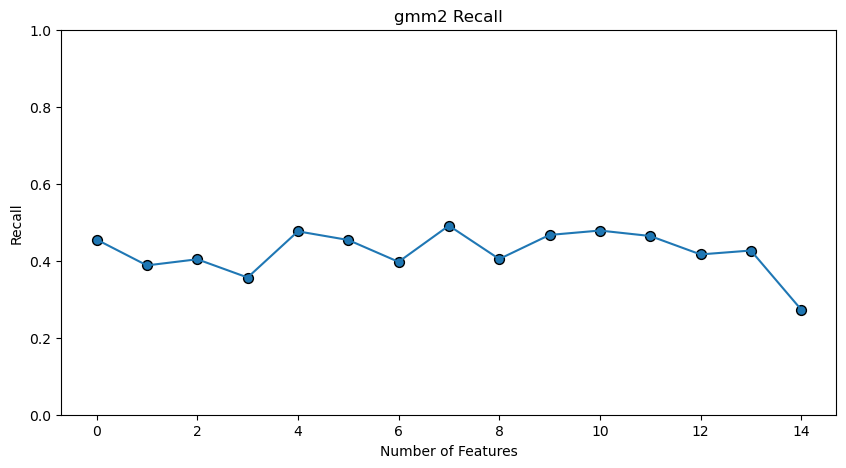

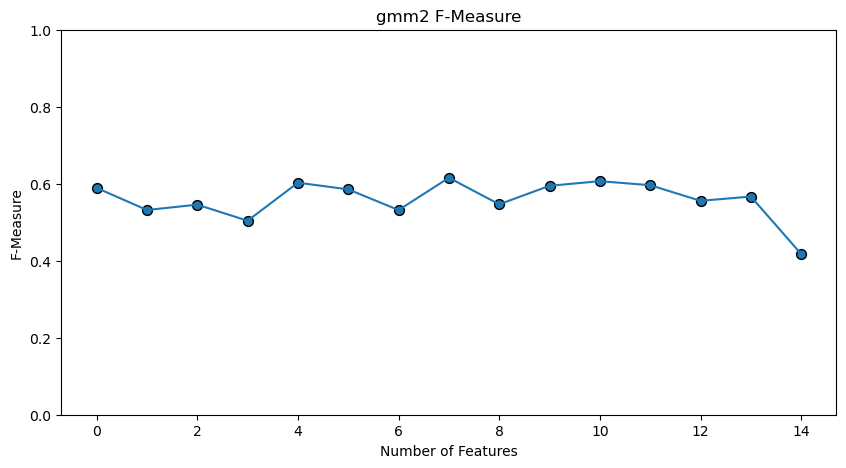

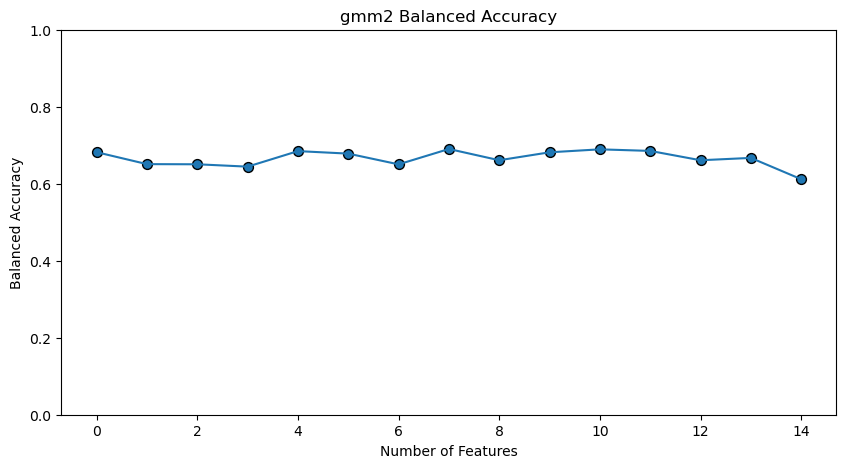

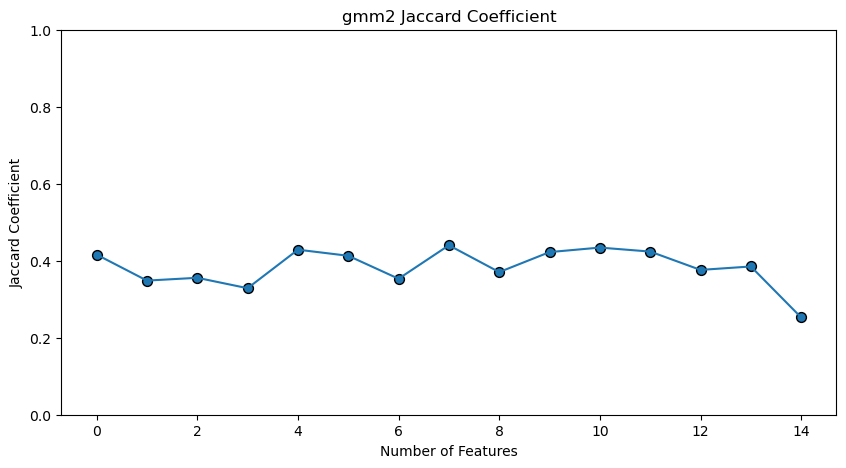

In [40]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm2RS, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm2RS)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Rand Statistic")
ax.set_title("gmm2 Rand Statistic")
ax.set_ylim([0,1])

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm2Precision, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm2Precision)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Precision")
ax.set_title("gmm2 precision")
ax.set_ylim([0,1])


fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm2Recall, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm2Recall)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Recall")
ax.set_title("gmm2 Recall")
ax.set_ylim([0,1])



fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm2F2, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm2F2)
ax.set_xlabel("Number of Features")
ax.set_ylabel("F-Measure")
ax.set_title("gmm2 F-Measure")
ax.set_ylim([0,1])




fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm2Balanced, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm2Balanced)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Balanced Accuracy")
ax.set_title("gmm2 Balanced Accuracy")
ax.set_ylim([0,1])


fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm2JC, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm2JC)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Jaccard Coefficient")
ax.set_title("gmm2 Jaccard Coefficient")
ax.set_ylim([0,1])



In [43]:
temp = np.max(gmm2Precision)
print("The maximum precision was", temp)
temp = np.max(gmm2Recall)
print("The maximum nontrivial recall was", temp)
temp = np.max(gmm2F2)
print("The maximum F-measure was", temp)
temp = np.max(gmm2Balanced)
print("The maximum balanced accuracy was", temp)
temp = np.max(gmm2RS)
print("The maximum Rand Statistic was", temp)
temp = np.max(gmm2JC)
print("The maximum Jaccard Coefficient was", temp)

The maximum precision was 0.8857711363700584
The maximum nontrivial recall was 0.49113444152814234
The maximum F-measure was 0.6154739407408354
The maximum balanced accuracy was 0.6901981903733331
The maximum Rand Statistic was 0.6909500290528763
The maximum Jaccard Coefficient was 0.4401320604755258


In [47]:
temp = np.average(gmm2Precision)
print("The average precision was", temp)
temp = np.average(gmm2Recall)
print("The average nontrivial recall was", temp)
temp = np.average(gmm2F2)
print("The average F-measure was", temp)
temp = np.average(gmm2Balanced)
print("The average balanced accuracy was", temp)
temp = np.average(gmm2RS)
print("The average Rand Statistic was", temp)
temp = np.average(gmm2JC)
print("The average Jaccard Coefficient was", temp)

The average precision was 0.8360623558757259
The average nontrivial recall was 0.4234140176922329
The average F-measure was 0.5592669462076902
The average balanced accuracy was 0.6658604097144233
The average Rand Statistic was 0.6667760991671509
The average Jaccard Coefficient was 0.38319249455989024


In [48]:
temp = np.var(gmm2Precision)
print("The variance of precision was", temp)
temp = np.var(gmm2Recall[1:])
print("The variance of recall was", temp)
temp = np.var(gmm2F2)
print("The variance of F-measure was", temp)
temp = np.var(gmm2Balanced)
print("The variance of balanced accuracy was", temp)
temp = np.var(gmm2RS)
print("The variance of Rand Statistic was", temp)
temp = np.var(gmm2JC)
print("The variance of Jaccard Coefficient was", temp)

The variance of precision was 0.00034442534962624997
The variance of recall was 0.003190779633707864
The variance of F-measure was 0.002438777349305869
The variance of balanced accuracy was 0.0004447435119968574
The variance of Rand Statistic was 0.00043943828254866394
The variance of Jaccard Coefficient was 0.0024097692406428333


# Evaluation of GMM With 4 Clusters

(0.0, 1.0)

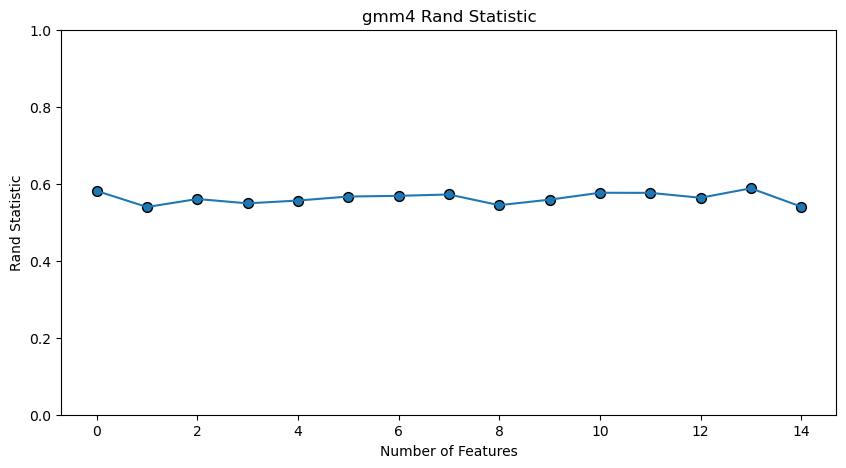

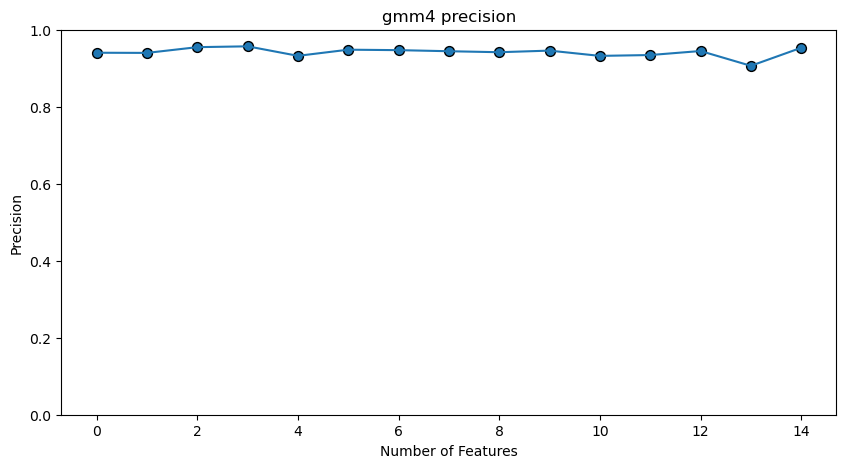

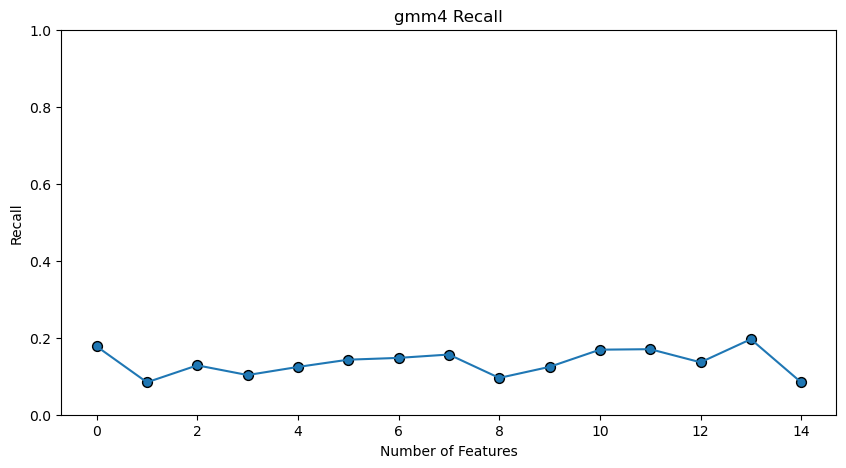

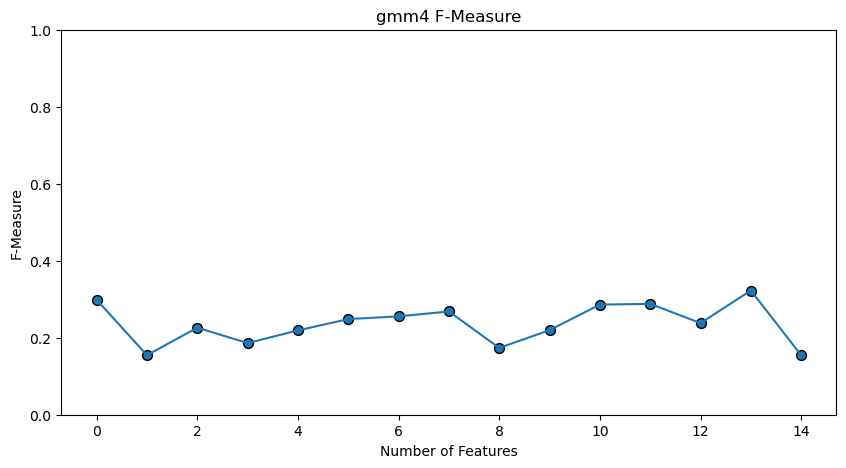

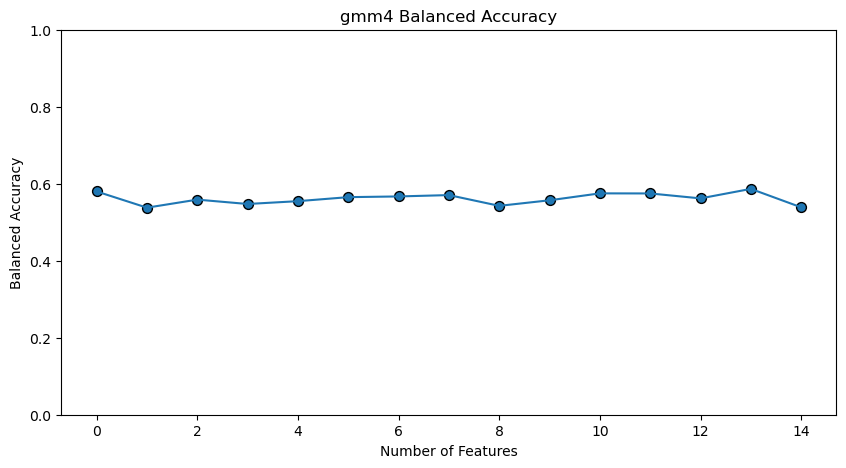

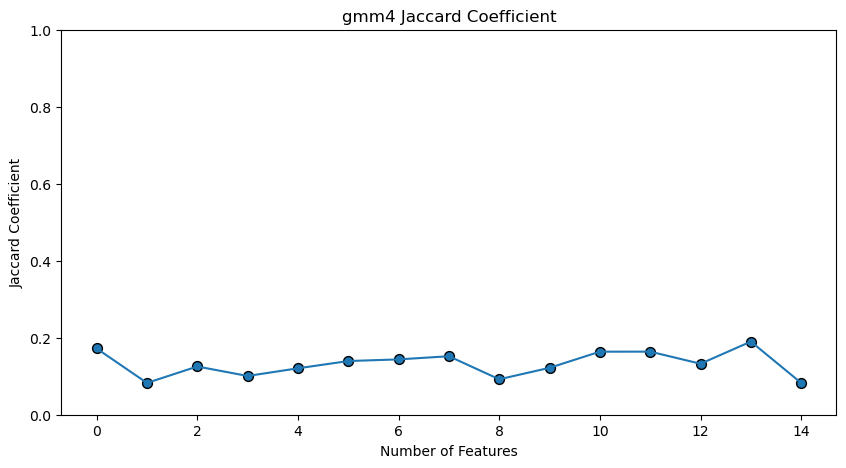

In [49]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm4RS, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm4RS)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Rand Statistic")
ax.set_title("gmm4 Rand Statistic")
ax.set_ylim([0,1])


fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm4Precision, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm4Precision)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Precision")
ax.set_title("gmm4 precision")
ax.set_ylim([0,1])


fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm4Recall, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm4Recall)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Recall")
ax.set_title("gmm4 Recall")
ax.set_ylim([0,1])



fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm4F2, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm4F2)
ax.set_xlabel("Number of Features")
ax.set_ylabel("F-Measure")
ax.set_title("gmm4 F-Measure")
ax.set_ylim([0,1])




fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm4Balanced, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm4Balanced)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Balanced Accuracy")
ax.set_title("gmm4 Balanced Accuracy")
ax.set_ylim([0,1])


fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(hoAxis, gmm4JC, s=50, facecolor='C0', edgecolor='k')
ax.plot(hoAxis, gmm4JC)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Jaccard Coefficient")
ax.set_title("gmm4 Jaccard Coefficient")
ax.set_ylim([0,1])



In [50]:
temp = np.max(gmm4Precision)
print("The maximum precision was", temp)
temp = np.max(gmm4Recall)
print("The maximum nontrivial recall was", temp)
temp = np.max(gmm4F2)
print("The maximum F-measure was", temp)
temp = np.max(gmm4Balanced)
print("The maximum balanced accuracy was", temp)
temp = np.max(gmm4RS)
print("The maximum Rand Statistic was", temp)
temp = np.max(gmm4JC)
print("The maximum Jaccard Coefficient was", temp)

The maximum precision was 0.9568792648735694
The maximum nontrivial recall was 0.19617964421114029
The maximum F-measure was 0.32253909222818955
The maximum balanced accuracy was 0.58658475698256
The maximum Rand Statistic was 0.5880592678675188
The maximum Jaccard Coefficient was 0.18998510173612534


In [51]:
temp = np.average(gmm4Precision)
print("The average precision was", temp)
temp = np.average(gmm4Recall)
print("The average nontrivial recall was", temp)
temp = np.average(gmm4F2)
print("The average F-measure was", temp)
temp = np.average(gmm4Balanced)
print("The average balanced accuracy was", temp)
temp = np.average(gmm4RS)
print("The average Rand Statistic was", temp)
temp = np.average(gmm4JC)
print("The average Jaccard Coefficient was", temp)

The average precision was 0.9413764737724802
The average nontrivial recall was 0.13596772625644019
The average F-measure was 0.23592954881440534
The average balanced accuracy was 0.5611599364519056
The average Rand Statistic was 0.5627658338175479
The average Jaccard Coefficient was 0.13217059049627586


In [52]:
temp = np.var(gmm4Precision)
print("The variance of precision was", temp)
temp = np.var(gmm4Recall[1:])
print("The variance of recall was", temp)
temp = np.var(gmm4F2)
print("The variance of F-measure was", temp)
temp = np.var(gmm4Balanced)
print("The variance of balanced accuracy was", temp)
temp = np.var(gmm4RS)
print("The variance of Rand Statistic was", temp)
temp = np.var(gmm4JC)
print("The variance of Jaccard Coefficient was", temp)

The variance of precision was 0.0001419106572500356
The variance of recall was 0.0010563164772923986
The variance of F-measure was 0.0025678706216198583
The variance of balanced accuracy was 0.00021074391628964341
The variance of Rand Statistic was 0.00020869483990981787
The variance of Jaccard Coefficient was 0.0010215433634386177


# Data Visualization

In [54]:

v_pca =scaled_data


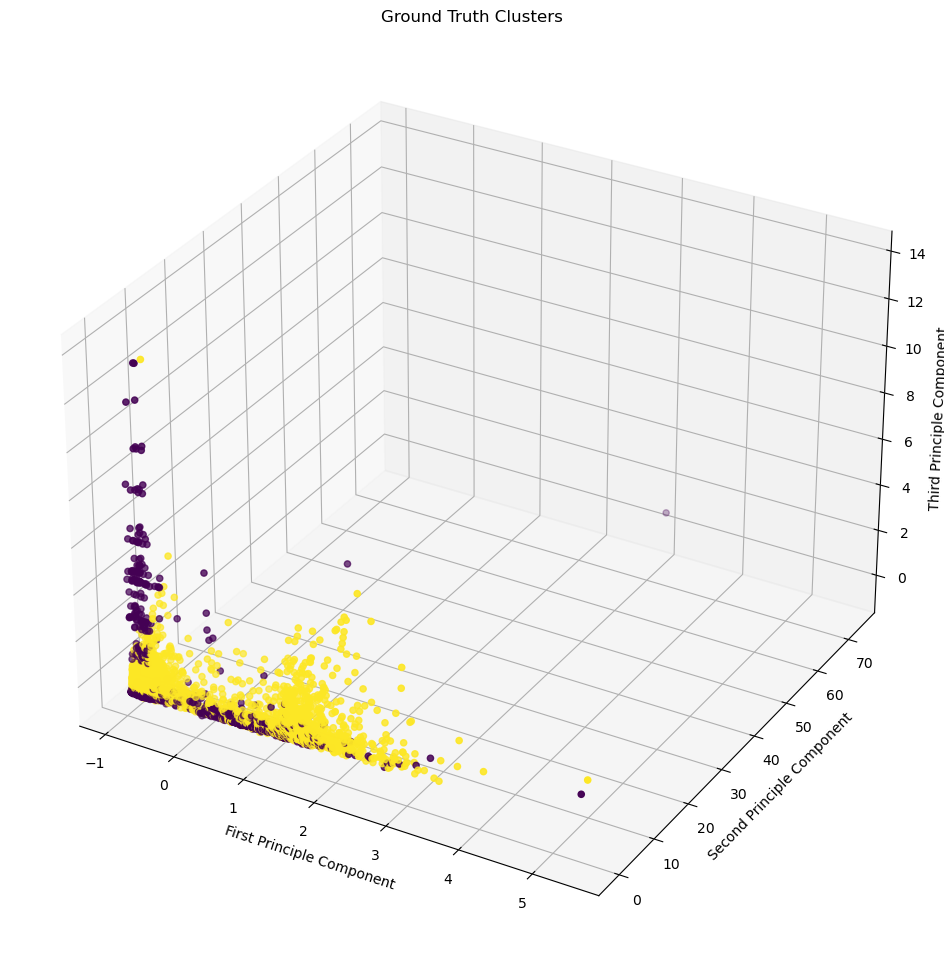

In [55]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(v_pca[:,0], v_pca[:,1], v_pca[:,2], c=y_test)
plt.xlabel("First Principle Component")
plt.ylabel("Second Principle Component")
ax.set_zlabel("Third Principle Component")
plt.title("Ground Truth Clusters")

plt.show()

## K-Means Visualization

Text(0.5, 0.92, 'Kmeans Clusters')

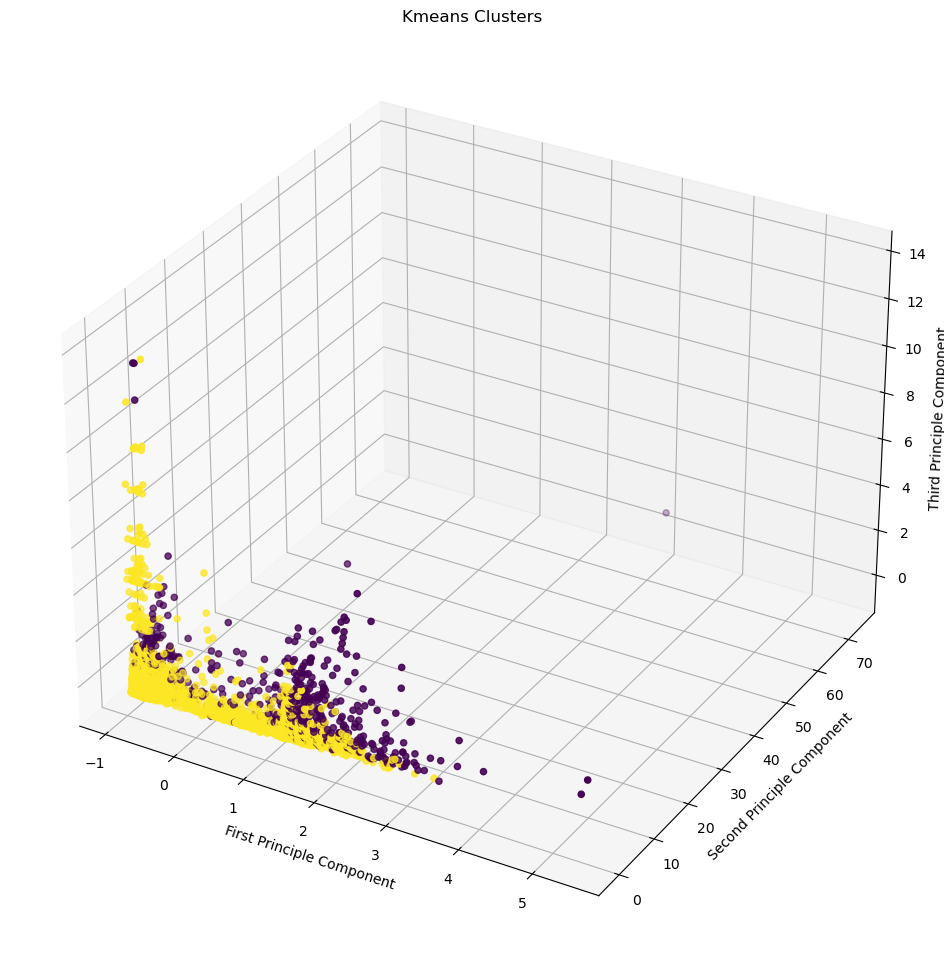

In [56]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init='auto').fit(v_pca)
kmeansY = kmeans.predict(v_pca)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(v_pca[:,0], v_pca[:,1], v_pca[:,2], c=kmeansY)
plt.xlabel("First Principle Component")
plt.ylabel("Second Principle Component")
ax.set_zlabel("Third Principle Component")
plt.title("Kmeans Clusters")

## GMM=2 Data Visualization

Text(0.5, 0.92, 'GMM=2 Clusters')

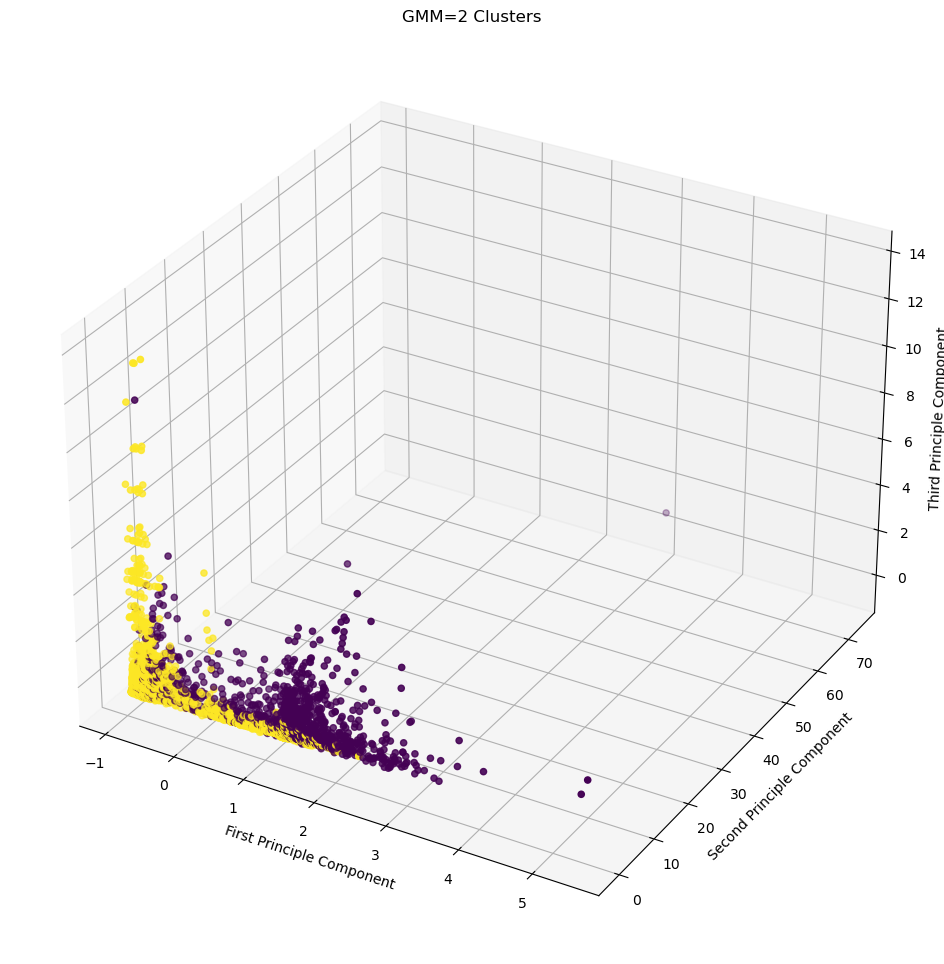

In [57]:
gmm2 = GaussianMixture(n_components=2, init_params='k-means++').fit(v_pca)
gmm2Y = gmm2.predict(v_pca)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(v_pca[:,0], v_pca[:,1], v_pca[:,2], c=gmm2Y)
plt.xlabel("First Principle Component")
plt.ylabel("Second Principle Component")
ax.set_zlabel("Third Principle Component")
plt.title("GMM=2 Clusters")

## GMM=4 Data Visualization

Text(0.5, 0.92, 'GMM = 4 Assignments')

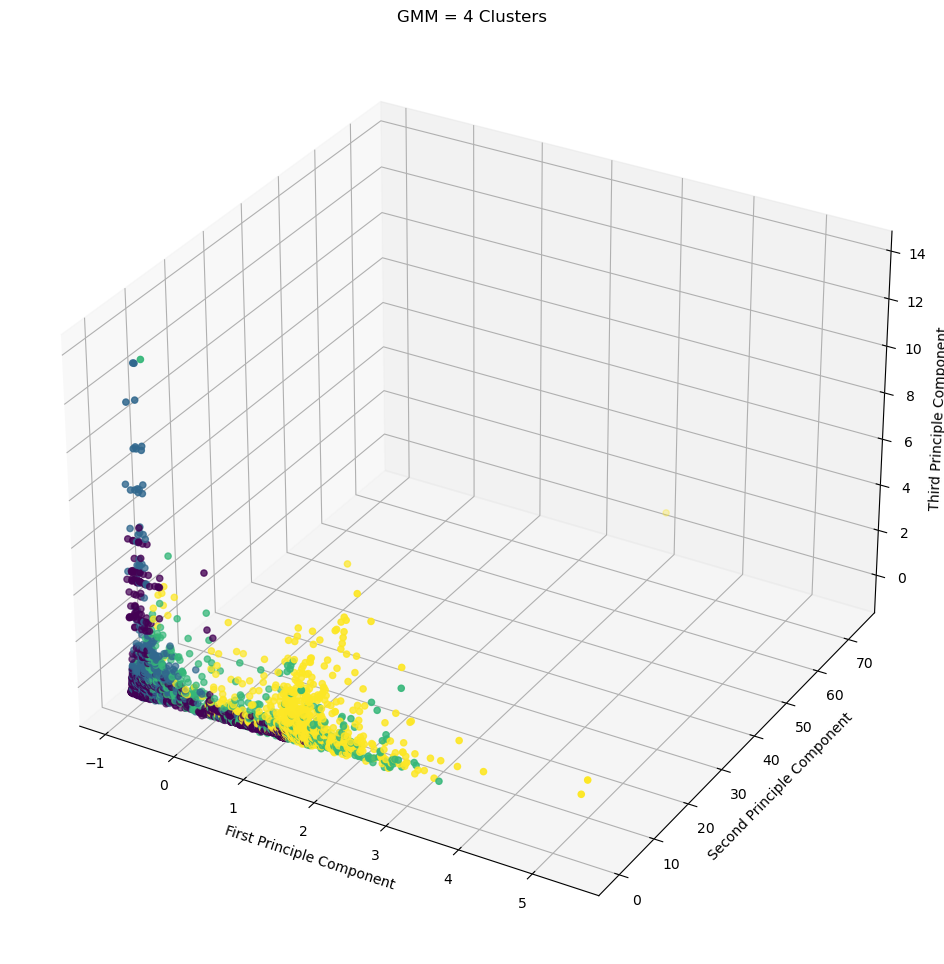

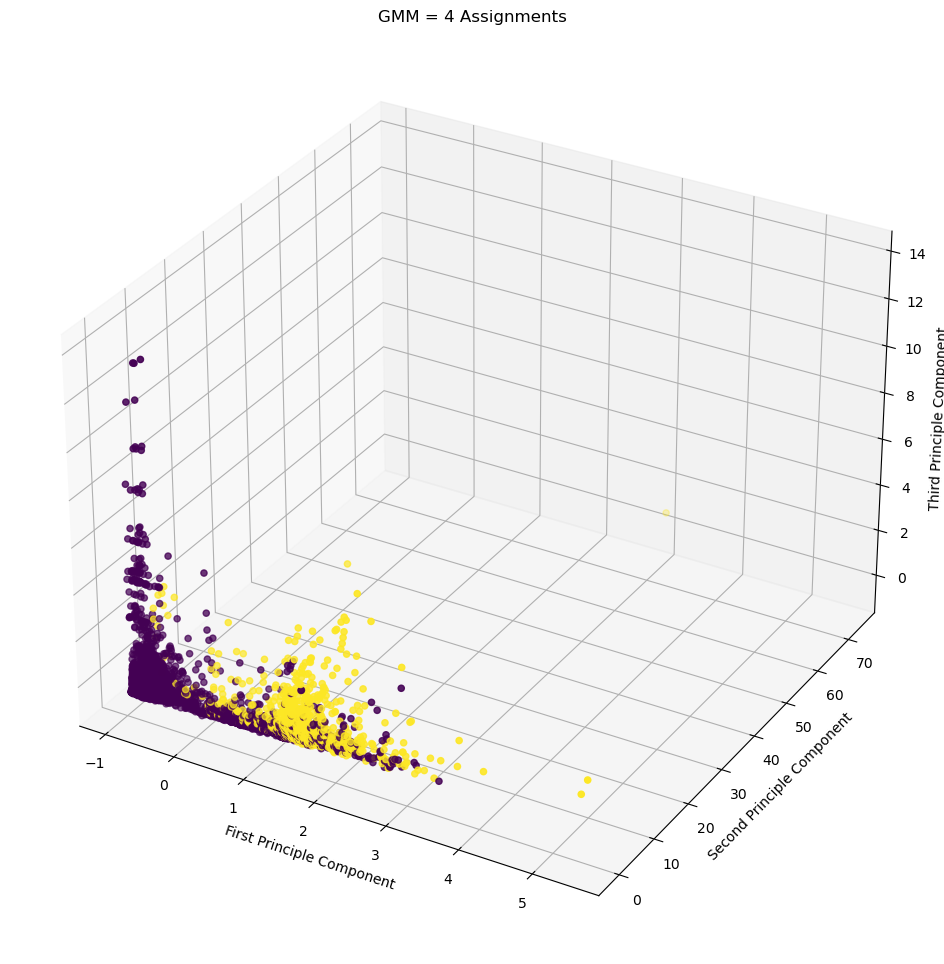

In [58]:
gmm4 = GaussianMixture(n_components=4, init_params='k-means++').fit(v_pca)
gmm4Y = gmm4.predict(v_pca)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(v_pca[:,0], v_pca[:,1], v_pca[:,2], c=gmm4Y)
plt.xlabel("First Principle Component")
plt.ylabel("Second Principle Component")
ax.set_zlabel("Third Principle Component")
plt.title("GMM = 4 Clusters")

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(v_pca[:,0], v_pca[:,1], v_pca[:,2], c=gmm4Y == getMaxCluster(gmm4Y))
plt.xlabel("First Principle Component")
plt.ylabel("Second Principle Component")
ax.set_zlabel("Third Principle Component")
plt.title("GMM = 4 Assignments")

# Summary of Results

## Kmeans

The data was cleaned with a k-nearest neighbors algorithm before being fitted to different models and subjected to principle component analysis. Categorical features were one hot encoded, and the dataset was downsampled to provide a balanced dataset. The data was then sent through a series of tests in which an increasing number of principle components were included. For each number of principle components considered, a k-means algorithm was ran 10 times with various data measures collected. The average results of the clustering evaluations was graphed and analyzed above. Over the various tests, the k-means algorithm had an average balanced accuracy of 0.59 and an average F-Measure of 0.32. These results show that the linear boundaries of k-means did not give a good reprisentation of the highly nonlinear data. The convergence to high error results implies that k-means is not capable of adequately modeling the data.

## GMM

The data was prepared identically to k-means, and a similar battery of tests were ran with increasing numbers of principle components included. For the sake of rigor and completeness, a gaussian mixture of 2 components and 4 components were both tested. In a round of preliminary testing, the average log likelihoods of gaussian mixture models with various numbers of components were collected, and 4 clusters was identified as the best performer via the elbow method. The binary gaussian mixture had an average balanced accuracy of 0.67, and an average F-Measure of 0.56. The 4-component mixture had an average balanced accuracy of 0.56, and an average F-Measure of 0.24. Overall, the gaussian models did not show a sufficient improvement over k-means. Their convergences to high error results imply they the gaussian mixture model is not capable of adequately modeling the data.